In [37]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm as _tqdm
import gym
import argparse
import copy
from gridworld import GridworldEnv
from tqdm import tqdm
import pickle

from contextlib import contextmanager
import sys, os

from DQN_model import QNetwork
from DQN_replay import ReplayMemory
from DQN_policy import EpsilonGreedyPolicy, get_epsilon
from DQN_training import train
from DQN_plots import plot_smooth
from DQN_main import run_episodes

In [38]:
# From https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python
@contextmanager
def suppress_stdout(suppress):
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        if suppress:
            sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [39]:
def plot_with_error(losses, unc=True, filename=None, plot_label="Loss", colour='blue'):
    losses = np.array(losses)
    
    means = np.mean(losses, axis=0)
    errors = np.std(losses, axis=0)
    
    if unc: # Plot uncertainty instead of std
        errors = errors / np.sqrt(losses.shape[0])
    
    x = np.arange(len(means))
    
    fig, ax = plt.subplots(1)
    ax.plot(x, means, lw=2, label=f"Mean {plot_label}", color=colour)
    ax.fill_between(x, means+errors, means-errors, facecolor=colour, alpha=0.5)
    ax.legend(loc='upper left', fancybox=True)
    ax.set_xlabel('Episodes')
    ax.set_ylabel(plot_label)
    ax.grid()
    
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')


In [40]:
def pickle_tuple(tupl, filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'wb') as f:
        pickle.dump(tupl,f)

def unpickle_tuple(filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'rb') as f:
        return pickle.load(f)

In [41]:
def run_setting(env_name, num_episodes, batch_size, memory_size, discount_factor, learn_rate, seed, num_hidden, 
                min_eps, max_eps, anneal_time, clone_interval, clipping, suppress_printing):
    # mostly copied from main() in DQN_main.py, removed some code for overview
    # if you want replay to be turned off, use batch_size=memory_size=1
    # returns episode durations (list), losses averaged per step (list), max abs q averaged per step (list)
    
    env = GridworldEnv() if env_name == "GridWorldEnv" else gym.make(env_name)

    obs_shape = env.observation_space.shape
    num_actions = env.action_space.n
    obs_size = obs_shape[0] if len(obs_shape) > 0 else 1

    memory = ReplayMemory(memory_size)

    # for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    Q_net = QNetwork(obs_size, num_actions, num_hidden=num_hidden)
    policy = EpsilonGreedyPolicy(Q_net, num_actions)
    with suppress_stdout(suppress_printing):
        return run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, 
                            learn_rate, clone_interval, min_eps, max_eps, anneal_time, clipping)

In [ ]:
durations_list, losses_list, max_Qs_list = [], [], []
for seed in tqdm([1,2,3]):
    durations, losses, max_Qs = run_setting(env_name="CartPole-v1",
                                            num_episodes=100,
                                            batch_size=64, 
                                            memory_size=1, 
                                            discount_factor=0.9, 
                                            learn_rate=1e-4, 
                                            seed=seed, 
                                            num_hidden=128, 
                                            min_eps=0.05, 
                                            max_eps=1., 
                                            anneal_time=1000, 
                                            clone_interval=None, 
                                            clipping=True,
                                            suppress_printing=True)
    durations_list.append(durations)
    losses_list.append(losses)
    max_Qs_list.append(max_Qs)
filename = f"CartPole-v1_{seed}_"
pickle_tuple((durations_list, losses_list, max_Qs_list), filename=filename)

  0%|          | 0/3 [00:00<?, ?it/s]/home/daniel/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/mnt/20E2A17CE2A15736/Users/Public/Documents/Central Documents/Education/MSc AI UvA/Courses/Reinforcement Learning/Labs/DQN-Experiments/scripts/DQN_model.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)  # Seems like this does nothing, even when numpy gets passed into Q


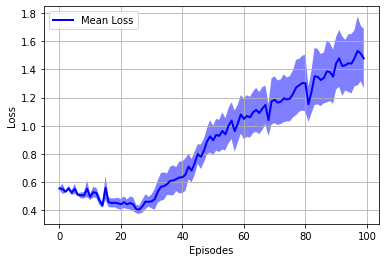

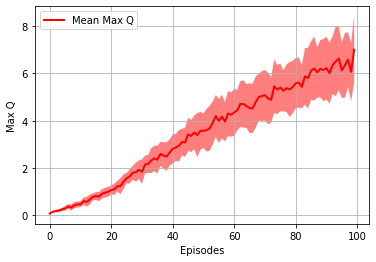

In [36]:
# example plot
plot_with_error(losses_list, unc=True, filename=filename, plot_label="Loss")
plot_with_error(max_Qs_list, unc=True, filename=filename+"_Q", plot_label="Max Q", colour='red')